In [1]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time
import os
import matplotlib.image as img
from PIL import Image

from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential


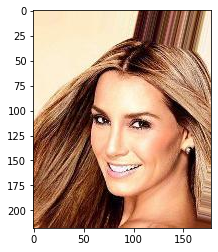

(218, 178, 3)


In [2]:
allImgPath = []
#fullImgPath = "C:/Users/Belg/Downloads/archive(1)/celeba_hq/val/female"
fullImgPath = "C:/Users/Belg/OneDrive - OST\Master's/02_Semester/VA/celeba/img_align_celeba"

for path in os.listdir(fullImgPath):
    if ".jpg" in path:
        allImgPath.append(os.path.join(fullImgPath,path))

image = img.imread(allImgPath[0])
plt.imshow(image)
plt.show()
print(image.shape)

In [3]:
partImgPath = allImgPath[50000:202599]
cropping = (0,20,178,208)

with tf.device('/CPU:0'):
    xTrain = [np.array((Image.open(path).convert('L').crop(cropping)).resize((128,128))) for path in partImgPath]

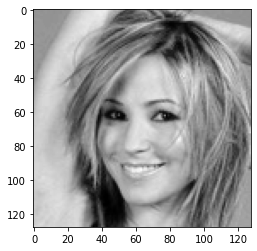

(128, 128)


In [4]:
plt.imshow(xTrain[0],cmap="gray")
plt.show()
print(xTrain[0].shape)

In [5]:
with tf.device('/CPU:0'):
    for i in range(len(xTrain)):
        xTrain[i] = xTrain[i]/127.5-1 #tanh -->[-1,1]

xTrain = np.array(xTrain)

In [6]:
#xTrain=xTrain[0:50000]
xTrain.shape

(152599, 128, 128)

<Figure size 720x720 with 0 Axes>

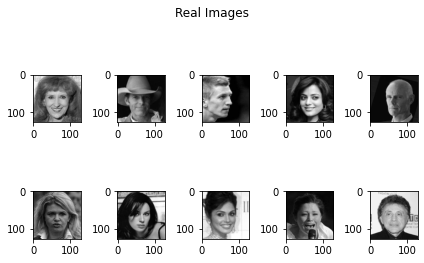

In [7]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(((xTrain[idx])* 0.5 + 0.5).reshape(128,128,1),cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [35]:
batchSize = 16
nepochs = 1000
nepochsD = 200
zDim = 100
imgShape = (128,128,1)
sampleInterval = 5

In [9]:
with tf.device('/CPU:0'):
    trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

<font style="color:red"><h1>Model Architecture </h1></font>

In [10]:
oldgenerator = K.models.load_model("Celeb_a_CNNgenerator")
oldgenerator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

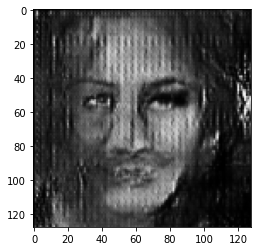

In [51]:
#generate noise image
generator = oldgenerator

noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5,cmap="gray")
plt.show()


In [12]:
discriminator = K.models.load_model("Celeb_a_CNNdiscriminator")
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)      

In [13]:
#classyfy with discriminator
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[1.5158187e-07]], shape=(1, 1), dtype=float32)


In [14]:
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan=buildGan(generator,discriminator)

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 1)       2108801   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 404225    
                                                                 
Total params: 2,513,026
Trainable params: 2,075,585
Non-trainable params: 437,441
_________________________________________________________________


In [15]:
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[1.5158172e-07]], shape=(1, 1), dtype=float32)


In [16]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

<font style="color:red"><h1>Train Discriminator </h1></font>

In [17]:
def train_step_discriminator(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])

    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)

In [18]:
def trainingDiscriminator():
  for epoch in range(nepochsD):
    start = time.time()

    for batch in trainDataset:
      train_step_discriminator(batch)
        
    if (epoch + 1) % sampleInterval ==0:
      print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
      print("Epoch: ",epoch + 1)
      print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

In [19]:
trainingDiscriminator()

Time for epoch 5 is 289.0 sec
Epoch:  5
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Time for epoch 10 is 285.0 sec
Epoch:  10
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Time for epoch 15 is 281.0 sec
Epoch:  15
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Time for epoch 20 is 279.0 sec
Epoch:  20
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Time for epoch 25 is 276.0 sec
Epoch:  25
--------------------------------------------------------------------------------------------------------------------------------------------------------

<font style="color:red"><h1>Train GAN </h1></font>

In [20]:
def train_step(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])

    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)
    disLoss, acc = 0.5*tf.add(dreal,dfake)
    
    discriminator.trainable = False
    genLoss = gan.train_on_batch(noise,real)

      
    return genLoss,disLoss,acc*100

In [21]:
def training():
  for epoch in range(nepochs):
    start = time.time()

    for batch in trainDataset:
      train_step(batch)
      genLoss,disLoss,acc = train_step(batch)
        
    if (epoch + 1) % sampleInterval ==0:
      print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
      print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
      print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
      sampleImg(generator)

In [52]:
def sampleImg(generator,imgGridRow = 4, imgGridColumn = 4):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 5 is 785.0 sec
Epoch:  5 | Discriminator Loss:  113.65 | Accuracy:  50.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


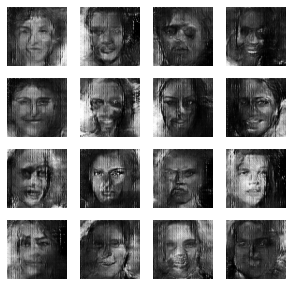

Time for epoch 10 is 799.0 sec
Epoch:  10 | Discriminator Loss:  130.79 | Accuracy:  50.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


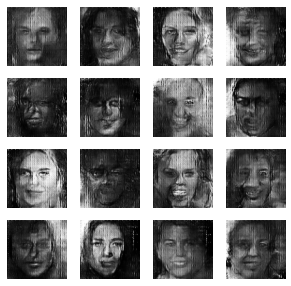

Time for epoch 15 is 791.0 sec
Epoch:  15 | Discriminator Loss:  133.09 | Accuracy:  50.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


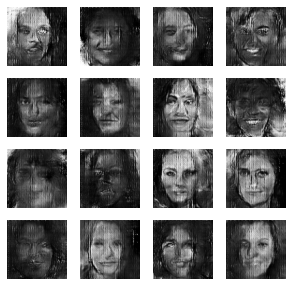

Time for epoch 20 is 798.0 sec
Epoch:  20 | Discriminator Loss:  129.75 | Accuracy:  42.86 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


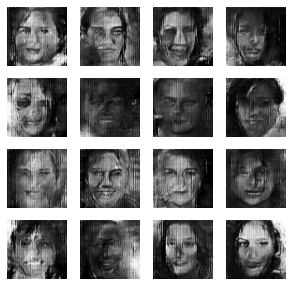

Time for epoch 25 is 796.0 sec
Epoch:  25 | Discriminator Loss:  121.73 | Accuracy:  42.86 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


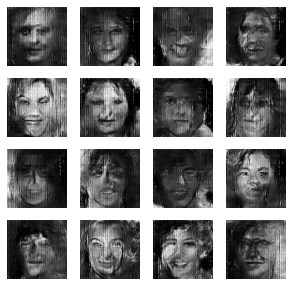

Time for epoch 30 is 798.0 sec
Epoch:  30 | Discriminator Loss:  126.62 | Accuracy:  50.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


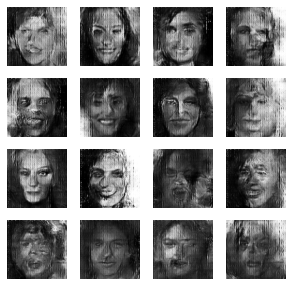

KeyboardInterrupt: 

In [53]:
training()

<font style="color:red"><h1>Save trained Model </h1></font>

In [ ]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
generator.save("128_Celeb_a_CNNgenerator")

discriminator.save("128_Celeb_a_CNNdiscriminator")

gan.save("128_Celeb_a_CNNgan")

INFO:tensorflow:Assets written to: Celeb_a_CNNgenerator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNdiscriminator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNgan\assets


In [ ]:
model = K.models.load_model("128_Celeb_a_CNNgenerator")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

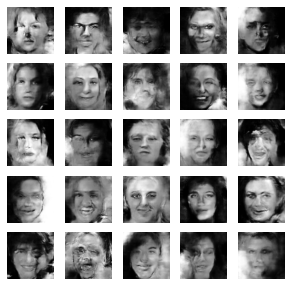

In [ ]:
sampleImg(model)

In [ ]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
plt.imshow(genImg[0]* 0.5 + 0.5,cmap="gray")
plt.show()

NameError: name 'model' is not defined